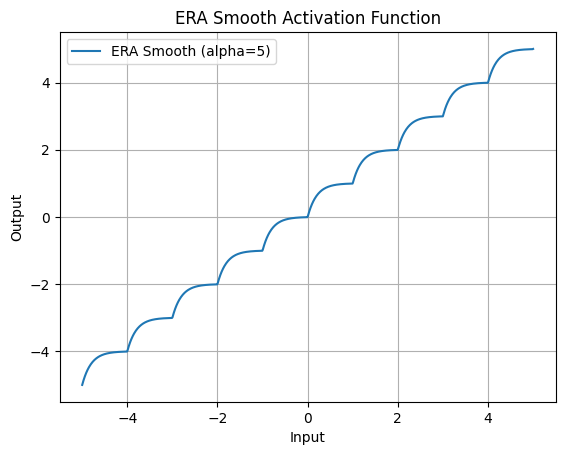


Training with era_smooth activation function...


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.metrics import confusion_matrix
import itertools

# Define the Exponential Range Activation (ERA) function with smooth transitions
class EraSmoothActivation(tf.keras.layers.Layer):
    def __init__(self, alpha=5, **kwargs):
        super(EraSmoothActivation, self).__init__(**kwargs)
        self.alpha = alpha

    def call(self, inputs):
        n = tf.floor(inputs)
        condition = tf.cast(inputs - n < 1, tf.float32)
        return n + (1 - tf.exp(-self.alpha * (inputs - n))) * condition

# Visualize era_smooth activation
def visualize_era_smooth(alpha=5):
    x = np.linspace(-5, 5, 1000)
    y = np.floor(x) + (1 - np.exp(-alpha * (x - np.floor(x)))) * (x - np.floor(x) < 1)
    plt.plot(x, y, label=f'ERA Smooth (alpha={alpha})')
    plt.title("ERA Smooth Activation Function")
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.legend()
    plt.grid(True)
    plt.show()


# Visualize era_smooth activation
visualize_era_smooth(alpha=5)

# Define ResNet block
def resnet_block(x, filters, activation):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = activation(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    if tf.shape(shortcut)[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x += shortcut
    x = activation(x)
    return x

# Define ResNet-20 model
def create_resnet_20(input_shape, num_classes, activation):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = activation(x)
    for _ in range(3):
        x = resnet_block(x, 16, activation)
    x = layers.Conv2D(32, (1, 1), strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = activation(x)
    for _ in range(3):
        x = resnet_block(x, 32, activation)
    x = layers.Conv2D(64, (1, 1), strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = activation(x)
    for _ in range(3):
        x = resnet_block(x, 64, activation)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

# Load CIFAR-10 dataset
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    return (x_train, y_train), (x_test, y_test)

# Plot feature maps for a single sample
def plot_feature_maps(model, x_sample, layer_name):
    layer_outputs = [layer.output for layer in model.layers if layer.name == layer_name]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(x_sample)
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle(f'Feature Maps for Layer: {layer_name}')
    for i, ax in enumerate(axes.flat):
        ax.imshow(activations[0, :, :, i], cmap='viridis')
        ax.axis('off')
    plt.show()

# Training and evaluation function
def train_and_evaluate(activation_layer, activation_name):
    (x_train, y_train), (x_test, y_test) = load_data()
    model = create_resnet_20((32, 32, 3), 10, activation=activation_layer())
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Track training time
    start_time = time()
    history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test), verbose=2)
    total_time = time() - start_time
    print(f"Total training time for {activation_name}: {total_time:.2f} seconds")

    # Plot feature maps after training
    print(f"\nFeature maps for first convolutional layer with {activation_name}:")
    plot_feature_maps(model, x_test[:1], layer_name="conv2d")

    # Evaluate model
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test accuracy for {activation_name}: {accuracy * 100:.2f}%")

    # Confusion matrix
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {activation_name}')
    plt.show()

    return history, total_time



# Train and compare models with era_smooth and ReLU activation functions
print("\nTraining with era_smooth activation function...")
history_era_smooth, time_era_smooth = train_and_evaluate(EraSmoothActivation, "ERA Smooth")

print("\nTraining with ReLU activation function...")
history_relu, time_relu = train_and_evaluate(lambda: tf.keras.layers.Activation('relu'), "ReLU")

# Comparison summary
print("\nComparison Summary:")
print(f"Total training time with ERA Smooth: {time_era_smooth:.2f} seconds")
print(f"Total training time with ReLU: {time_relu:.2f} seconds")


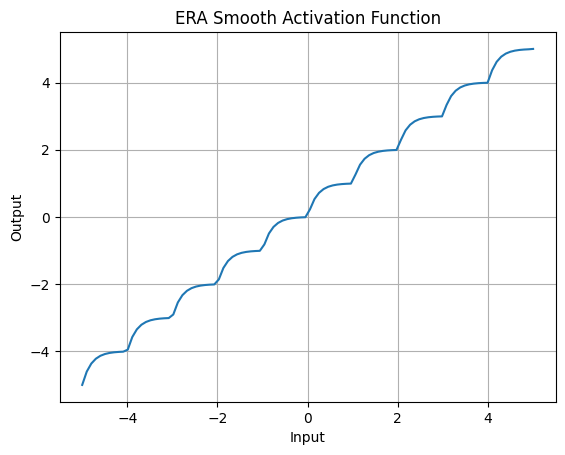


Training with ERA Smooth activation function...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1619s 2s/step - accuracy: 0.2479 - loss: 2.0960 - val_accuracy: 0.2716 - val_loss: 2.0275
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1565s 2s/step - accuracy: 0.3355 - loss: 1.8170 - val_accuracy: 0.3528 - val_loss: 1.7484
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1592s 2s/step - accuracy: 0.4119 - loss: 1.6096 - val_accuracy: 0.3523 - val_loss: 1.8117
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1585s 2s/step - accuracy: 0.4708 - loss: 1.4662 - val_accuracy: 0.3447 - val_loss: 1.7743
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1589s 2s/step - accuracy: 0.5178 - loss: 1.3474 - val_accuracy: 0.4115 - val_loss: 1.7054
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1588s 2s/step - accuracy: 0.5476 - loss: 1.2628 - val_accuracy: 0.4442 - val_loss: 1.6687
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1598s 2s/step - accuracy: 0.5697 - loss: 1.2174 - val_accuracy: 0.4620 - val_loss: 1.6840
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1

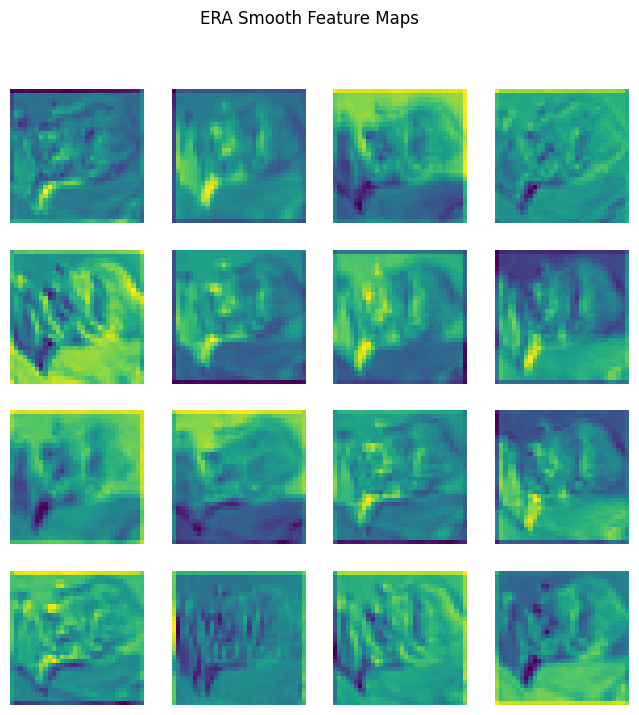


Training with ReLU activation function...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1287s 2s/step - accuracy: 0.4177 - loss: 1.5861 - val_accuracy: 0.3699 - val_loss: 2.2849
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1263s 2s/step - accuracy: 0.6309 - loss: 1.0329 - val_accuracy: 0.4250 - val_loss: 2.0438
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1263s 2s/step - accuracy: 0.6909 - loss: 0.8725 - val_accuracy: 0.6515 - val_loss: 1.0639
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1261s 2s/step - accuracy: 0.7324 - loss: 0.7623 - val_accuracy: 0.5600 - val_loss: 1.5826
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1266s 2s/step - accuracy: 0.7577 - loss: 0.6847 - val_accuracy: 0.4786 - val_loss: 1.8279
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1264s 2s/step - accuracy: 0.7829 - loss: 0.6146 - val_accuracy: 0.6509 - val_loss: 1.1319
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1262s 2s/step - accuracy: 0.8036 - loss: 0.5646 - val_accuracy: 0.6783 - val_loss: 1.0722
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1269s 2

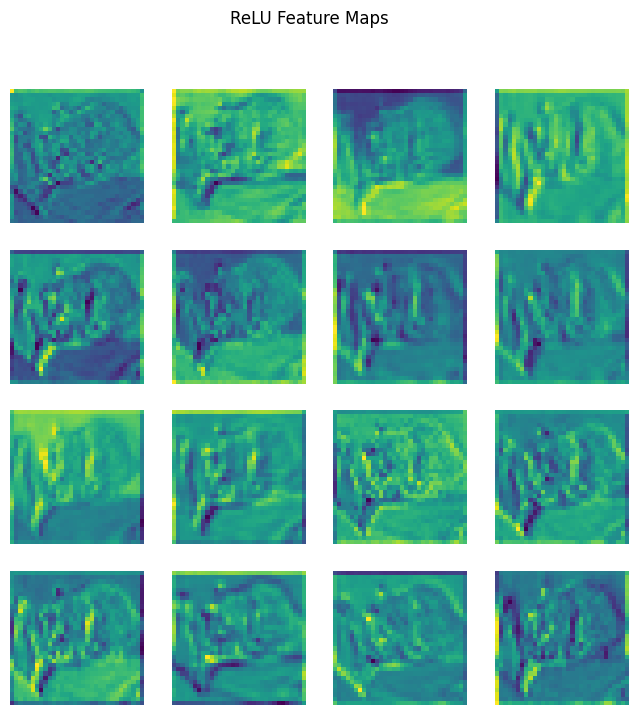

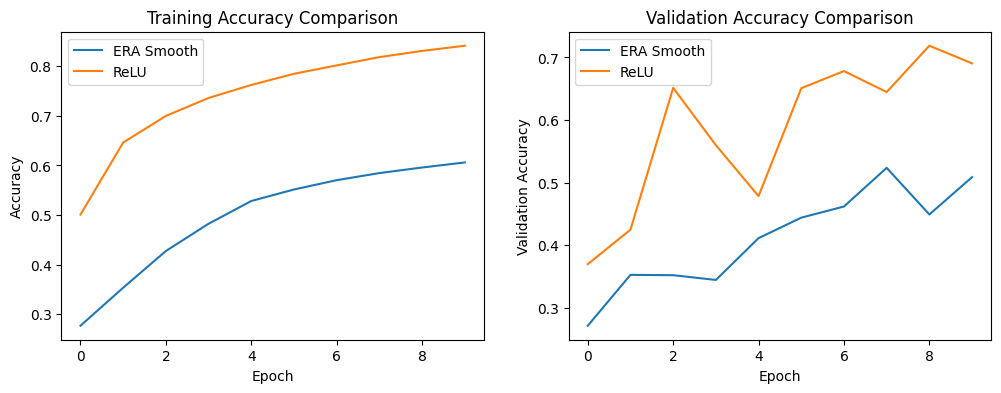

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, classification_report

# Define the Exponential Range Activation (ERA) function with smooth transitions
class EraSmoothActivation(tf.keras.layers.Layer):
    def __init__(self, alpha=5, **kwargs):
        super(EraSmoothActivation, self).__init__(**kwargs)
        self.alpha = alpha

    def call(self, inputs):
        n = tf.floor(inputs)
        condition = tf.cast(inputs - n < 1, tf.float32)
        return n + (1 - tf.exp(-self.alpha * (inputs - n))) * condition

# Visualization of the ERA Smooth activation function
def plot_era_smooth():
    x = np.linspace(-5, 5, 100)
    alpha = 5
    n = np.floor(x)
    condition = (x - n < 1).astype(float)
    y = n + (1 - np.exp(-alpha * (x - n))) * condition
    plt.plot(x, y)
    plt.title("ERA Smooth Activation Function")
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.grid()
    plt.show()

plot_era_smooth()

# Define ResNet-20 model
def resnet_block(x, filters, activation):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = activation(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Check if channel dimensions match, else project the shortcut
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([x, shortcut])
    x = activation(x)
    return x

def create_resnet_20(input_shape, num_classes, activation):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = activation(x)
    
    for _ in range(3):
        x = resnet_block(x, 16, activation)
    for _ in range(3):
        x = resnet_block(x, 32, activation)
    for _ in range(3):
        x = resnet_block(x, 64, activation)
    
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

# Load CIFAR-10 dataset
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    return (x_train / 255.0, y_train), (x_test / 255.0, y_test)

# Train and evaluate function
def train_and_evaluate(activation_layer, activation_name):
    (x_train, y_train), (x_test, y_test) = load_data()
    model = create_resnet_20((32, 32, 3), 10, activation=activation_layer())
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Track training time
    start_time = time.time()
    history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=64, verbose=1)
    total_time = time.time() - start_time
    
    # Evaluate model
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"{activation_name} Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Training Time for {activation_name}: {total_time:.2f} seconds")

    # Confusion matrix
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    print(f"{activation_name} Confusion Matrix:\n", conf_matrix)
    print(classification_report(y_true, y_pred_classes))

    # Plot feature maps
    feature_model = models.Model(inputs=model.inputs, outputs=model.layers[2].output)
    feature_map = feature_model.predict(np.expand_dims(x_test[0], axis=0))
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(feature_map[0, :, :, i], cmap='viridis')
        ax.axis('off')
    plt.suptitle(f"{activation_name} Feature Maps")
    plt.show()

    return history, total_time

# Train and compare models with ERA Smooth and ReLU activation functions
print("\nTraining with ERA Smooth activation function...")
history_era_smooth, time_era_smooth = train_and_evaluate(EraSmoothActivation, "ERA Smooth")

print("\nTraining with ReLU activation function...")
history_relu, time_relu = train_and_evaluate(lambda: tf.keras.layers.Activation('relu'), "ReLU")

# Plot training history
def plot_history(history_era, history_relu):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_era.history['accuracy'], label='ERA Smooth')
    plt.plot(history_relu.history['accuracy'], label='ReLU')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training Accuracy Comparison')

    plt.subplot(1, 2, 2)
    plt.plot(history_era.history['val_accuracy'], label='ERA Smooth')
    plt.plot(history_relu.history['val_accuracy'], label='ReLU')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.title('Validation Accuracy Comparison')
    plt.show()

plot_history(history_era_smooth, history_relu)


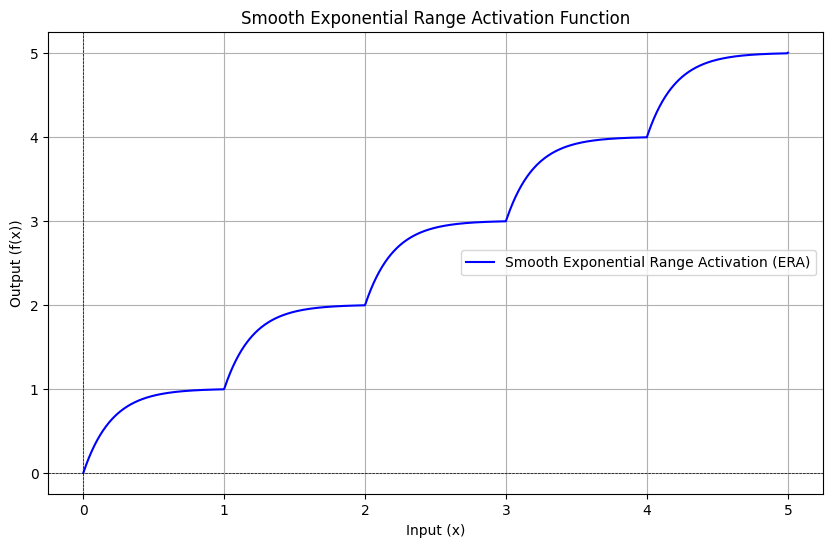

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Exponential Range Activation (ERA) function with smooth transitions
def era_smooth(x, alpha=5):
    # Get the integer part of x (floor)
    n = np.floor(x).astype(int)
    # Calculate the output for each x based on its interval with smooth transitions
    return n + (1 - np.exp(-alpha * (x - n))) * (x - n < 1)  # Apply the function only if x is in the interval

# Generate input values
x_values = np.linspace(0, 5, 1000)  # From 0 to 5, for multiple intervals
y_values = era_smooth(x_values)  # Apply the smooth ERA function

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Smooth Exponential Range Activation (ERA)', color='blue')
plt.title('Smooth Exponential Range Activation Function')
plt.xlabel('Input (x)')
plt.ylabel('Output (f(x))')
plt.grid()
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.xticks(np.arange(0, 6, 1))  # Show x ticks from 0 to 5
plt.yticks(np.arange(0, 6, 1))  # Show y ticks from 0 to 5
plt.legend()
plt.show()


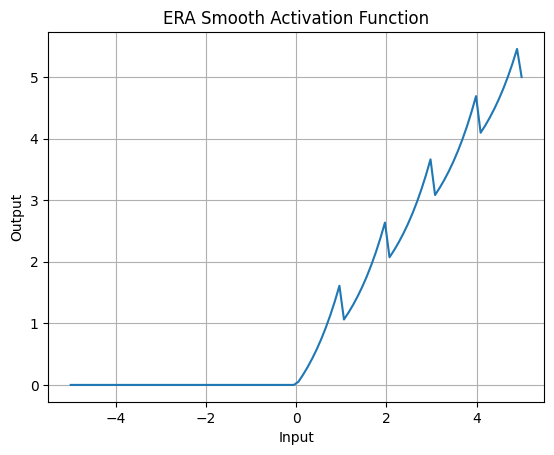


Training with ERA Smooth activation function...


MemoryError: Unable to allocate 586. MiB for an array with shape (50000, 32, 32, 3) and data type float32

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, classification_report

# Define the Exponential Range Activation (ERA) function with smooth transitions
class EraSmoothActivation(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EraSmoothActivation, self).__init__(**kwargs)

    def call(self, inputs):
        # For negative values of inputs, output is zero
        positive_part = tf.maximum(inputs, 0)
        
        # Exponential growth within each interval [n, n+1) for positive inputs
        fractional_part = tf.exp(tf.math.mod(positive_part, 1.0)) - 1
        
        # Adding the floor to create the staircase effect
        staircase_part = tf.floor(positive_part)
        
        # Combine both parts
        return staircase_part + fractional_part

# Visualization of the ERA Smooth activation function
# Visualization of the ERA Smooth activation function
def plot_era_smooth():
    x = np.linspace(-5, 5, 100)
    
    # Applying the EraSmoothActivation function
    y = np.vectorize(lambda x_val: EraSmoothActivation()(tf.convert_to_tensor(x_val, dtype=tf.float32)).numpy())(x)
    
    # Plot the ERA Smooth activation function
    plt.plot(x, y)
    plt.title("ERA Smooth Activation Function")
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.grid()
    plt.show()

plot_era_smooth()

# Define ResNet-20 model
def resnet_block(x, filters, activation):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = activation(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Check if channel dimensions match, else project the shortcut
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([x, shortcut])
    x = activation(x)
    return x

def create_resnet_20(input_shape, num_classes, activation):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = activation(x)
    
    for _ in range(3):
        x = resnet_block(x, 16, activation)
    for _ in range(3):
        x = resnet_block(x, 32, activation)
    for _ in range(3):
        x = resnet_block(x, 64, activation)
    
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

# Load CIFAR-10 dataset
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    return (x_train / 255.0, y_train), (x_test / 255.0, y_test)

# Train and evaluate function
def train_and_evaluate(activation_layer, activation_name):
    (x_train, y_train), (x_test, y_test) = load_data()
    model = create_resnet_20((32, 32, 3), 10, activation=activation_layer())
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Track training time
    start_time = time.time()
    history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=64, verbose=1)
    total_time = time.time() - start_time
    
    # Evaluate model
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"{activation_name} Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Training Time for {activation_name}: {total_time:.2f} seconds")

    # Confusion matrix
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    print(f"{activation_name} Confusion Matrix:\n", conf_matrix)
    print(classification_report(y_true, y_pred_classes))

    # Plot feature maps
    feature_model = models.Model(inputs=model.inputs, outputs=model.layers[2].output)
    feature_map = feature_model.predict(np.expand_dims(x_test[0], axis=0))
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(feature_map[0, :, :, i], cmap='viridis')
        ax.axis('off')
    plt.suptitle(f"{activation_name} Feature Maps")
    plt.show()

    return history, total_time

# Train and compare models with ERA Smooth and ReLU activation functions
print("\nTraining with ERA Smooth activation function...")
history_era_smooth, time_era_smooth = train_and_evaluate(EraSmoothActivation, "ERA Smooth")

print("\nTraining with ReLU activation function...")
history_relu, time_relu = train_and_evaluate(lambda: tf.keras.layers.Activation('relu'), "ReLU")

# Plot training history
def plot_history(history_era, history_relu):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_era.history['accuracy'], label='ERA Smooth')
    plt.plot(history_relu.history['accuracy'], label='ReLU')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training Accuracy Comparison')

    plt.subplot(1, 2, 2)
    plt.plot(history_era.history['val_accuracy'], label='ERA Smooth')
    plt.plot(history_relu.history['val_accuracy'], label='ReLU')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.title('Validation Accuracy Comparison')
    plt.show()

plot_history(history_era_smooth, history_relu)
